In [1]:
import os
import numpy as np
import discretisedfield as df
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors
from matplotlib import cm
from pathlib import Path
from matplotlib.animation import FuncAnimation, PillowWriter

## Instructions

1) Run the cell above to import all of the necessary packages. If you get an error, doublecheck that these are all installed.

2) In the cell below, edit the path to the folder containing your ovf files. Remember that './' refers to the folder this notebook is in. So that would mean that './folder1/folder2' tells python: starting from here, look in folder1, then folder2. You can also use '../' to search in the folder holding this one. Alternatively you can just copy the entire path to the ovf containing folder.

3) Run all of the cells from the very top until you reach the Image Maker section. These cells contain functions that break the whole process into easier to handle pieces.

4) Find the section you want to use (Image/gif maker, single/multi component), edit options found in the cell as necessary and run.

In [14]:
# Gathers .ovf files and places them into a list
pname = Path('./initialize/Holes/35um_2048.out') # path to the folder containing ".ovf" files
fnames = sorted(pname.glob('*.ovf')) # gets and sorts all the ".ovf" files into a list called fnames

In [3]:
# Here are some global variables for making plots
norm = colors.CenteredNorm() # this ensures the color map is centered around zero
cmap = cm.coolwarm # color map, can be changed without breaking the script
lbl = ['x','y','z'] # labels for magnetization components

## Functions

In [4]:
# this function takes an ovf file from the fnames list and returns an array of magnetization values
# the layer option chooses the 2D magnetization at the given layer; if layer=None, integrate mag. along z

def ovf_to_array(fname, layer=None):
    m = df.Field.fromfile(str(fname))
    if layer==None:
        m_array = m.project('z').array[:,:,0,:]
    else:
        m_array = m.array[:,:,layer,:]
    arr = np.transpose(m_array, [1,0,2])
    return arr

In [5]:
# this function plots one component of the 2D magnetization returned by ovf_to_array
# options to choose layer, mag. component (x=0,y=1,z=2), and image cropping
# crops must be entered as lists of bounds: [xmin,xmax] and [ymin,ymax]

def plot_ovf(fname, layer, component = 2, cropx = [None,None], cropy = [None,None]):
    m = ovf_to_array(fname,layer)
    arr = m[cropy[0]:cropy[1],cropx[0]:cropx[1],component]
    pc = ax.pcolormesh(arr, norm=norm, cmap=cmap)
    ax.set_title(f'Magnetization {lbl[component]}-component ({str(fname)[-6:-4]} L{layer})')

    plt.show()

In [6]:
# this function plots all three components of the 2D magnetization returned by ovf_to_array side by side
# options to choose layer and image cropping
# crops must be entered as lists of bounds: [xmin,xmax] and [ymin,ymax]

def plot_ovf_all(fname, layer, cropx = [None,None], cropy = [None,None]):
    m = ovf_to_array(fname, layer)
    arr0 = m[cropy[0]:cropy[1],cropx[0]:cropx[1],0]
    arr1 = m[cropy[0]:cropy[1],cropx[0]:cropx[1],1]
    arr2 = m[cropy[0]:cropy[1],cropx[0]:cropx[1],2]
    
    pc0 = ax[0].pcolormesh(arr0, norm=norm, cmap=cmap)
    pc1 = ax[1].pcolormesh(arr1, norm=norm, cmap=cmap)
    pc2 = ax[2].pcolormesh(arr2, norm=norm, cmap=cmap)

    ax[0].set_title(lbl[0]+'-component')
    ax[1].set_title(lbl[1]+'-component')
    ax[2].set_title(lbl[2]+'-component')
    fig.suptitle(f'Magnetization ({str(fname)[-7:-4]} L{layer})')
    
    plt.show()

In [7]:
# this function warns the user if the ovf resolution exceeds 
def get_res_warning(arr,ax):
    arr_height,arr_width = arr.shape
    px_height,px_width = ax.get_window_extent().height,ax.get_window_extent().width
    if (arr_height>px_height) or (arr_width>px_width):
        print('WARNING: figsize and dpi are not large enough to display cells from the .ovf file!')

In [8]:
# this function initializes the figure with one component plot

def make_1comp_fig(layer, component, cropx, cropy, figsize=(8,8), dpi=72.0):
    m = ovf_to_array(fnames[0],layer)
    arr = m[cropy[0]:cropy[1],cropx[0]:cropx[1],component]

    fig, ax = plt.subplots(figsize=figsize)
    fig.tight_layout()
    fig.set_dpi(dpi)
    ax.set_aspect('equal')
    ax.apply_aspect()
    pc = ax.pcolormesh(arr, norm=norm, cmap=cmap)
    
    ax.set_title(f'Magnetization {lbl[component]}-component ({str(fname)[-6:-4]} L{layer})')
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.1)
    bounds = np.linspace(-1,1,100,endpoint=True)
    ticks = np.linspace(-1,1,3,endpoint=True)
    fig.colorbar(pc,cax=cax,boundaries=bounds,ticks=ticks)
    
    get_res_warning(arr,ax)
            
    return fig, ax, dpi

In [9]:
# this function initialzies the figure with three component plots

def make_3comp_fig(i, layer, cropx, cropy, figsize=(24,8), dpi=72.0):
    m = ovf_to_array(fnames[0],layer)
    arr0 = m[cropy[0]:cropy[1],cropx[0]:cropx[1],0]
    arr1 = m[cropy[0]:cropy[1],cropx[0]:cropx[1],1]
    arr2 = m[cropy[0]:cropy[1],cropx[0]:cropx[1],2]

    fig, ax = plt.subplots(ncols=3, figsize=figsize, constrained_layout=1)
    fig.set_dpi(dpi)
    ax[0].set_aspect('equal')
    ax[1].set_aspect('equal')
    ax[2].set_aspect('equal')
    pc0 = ax[0].pcolormesh(arr0, norm=norm, cmap=cmap)
    pc1 = ax[1].pcolormesh(arr1, norm=norm, cmap=cmap)
    pc2 = ax[2].pcolormesh(arr2, norm=norm, cmap=cmap)
    
    ax[0].set_title(lbl[0]+'-component')
    ax[1].set_title(lbl[1]+'-component')
    ax[2].set_title(lbl[2]+'-component')
    fig.suptitle(f'Magnetization ({str(fname)[-7:-4]} L{layer})')
    
    bounds = np.linspace(-1,1,100,endpoint=True)
    ticks = np.linspace(-1,1,5,endpoint=True)
    fig.colorbar(pc,ax=ax,location='bottom',boundaries=bounds,ticks=ticks,shrink=0.50)
    
    get_res_warning(arr0,ax0)
    
    return fig, ax, dpi

## Image makers

### single component

In [15]:
# Checks that at least one ovf file has been found
fname = fnames[10]
print(fname)

initialize/Holes/35um_2048.out/m000010.ovf


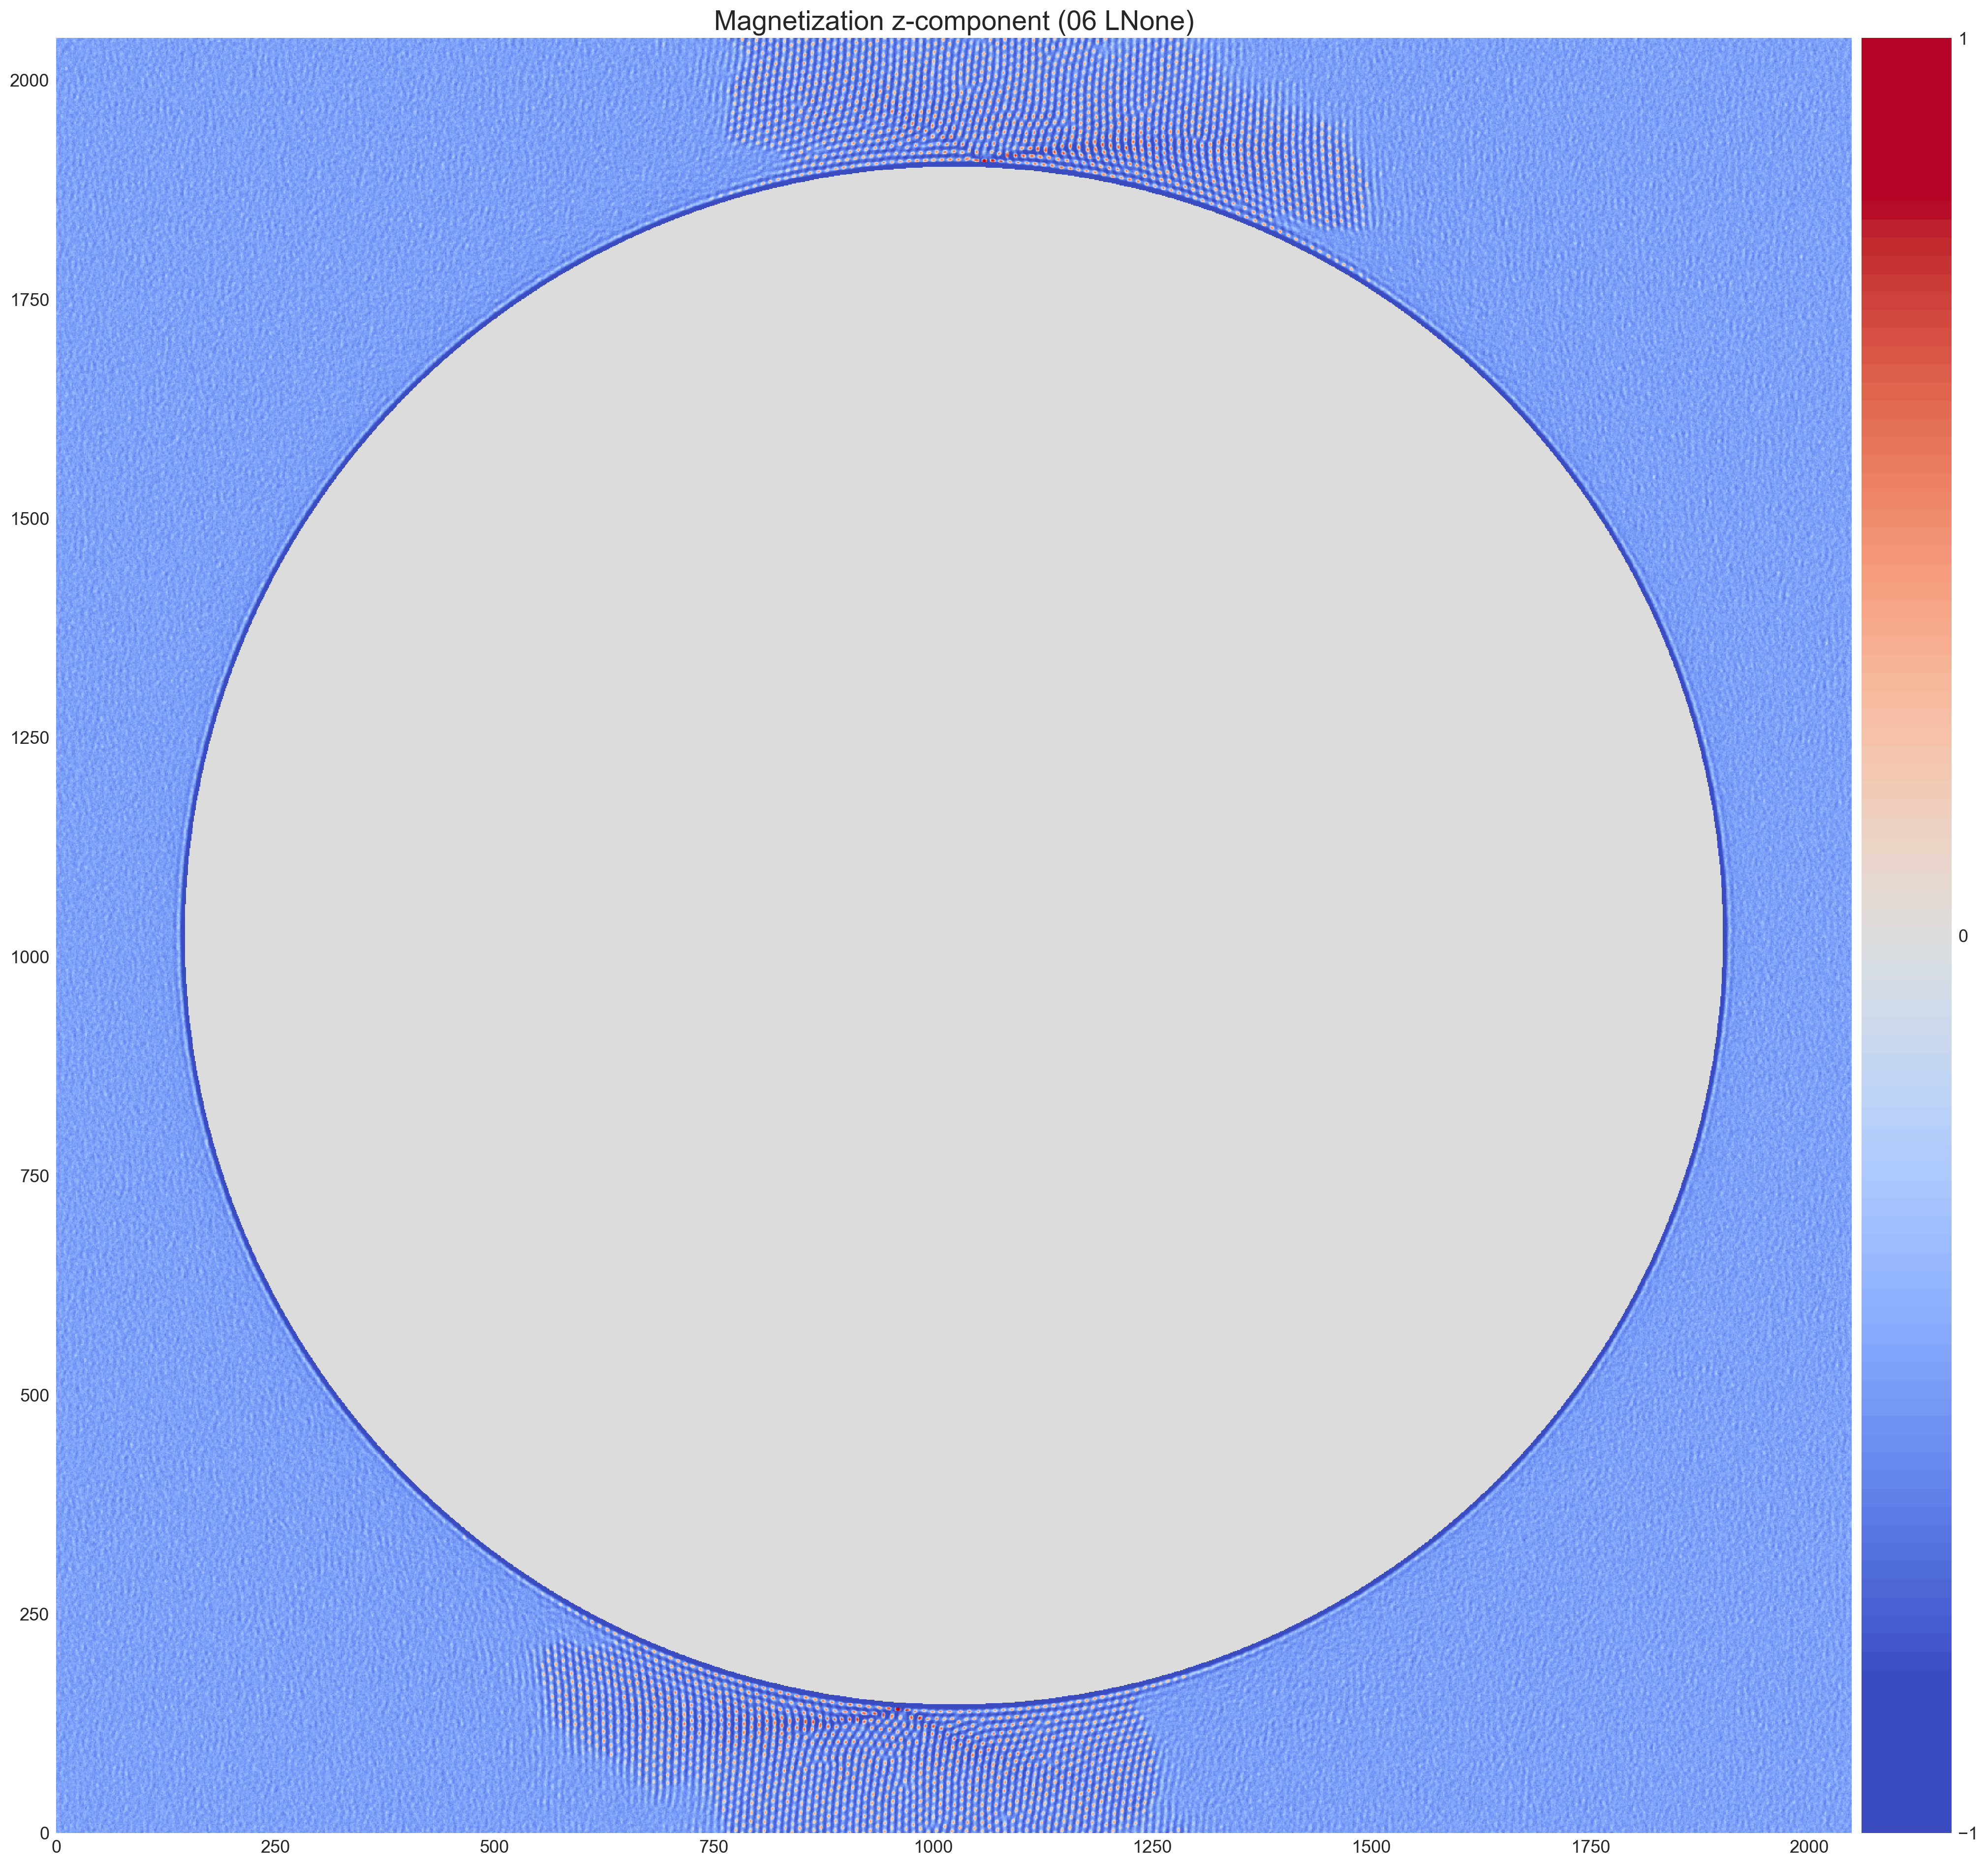

In [17]:
i = 6 # choose which ovf file to process
component = 2 # choose which component of the magnetization to plot
layer = None # choose which layer to plot, layer=None will integrate the magnetization through the material.
cropx = [None,None] # crops the image in the x direction, formatting: cropx=[xmin,xmax]
cropy = [None,None] # crops the image in the y direction, formatting: cropy=[ymin,ymax]
#cropx = [236,276]
#cropy = [0,80]

# this section initializes the figure shape, color map, and color bar
fig,ax,_ = make_1comp_fig(layer, component, cropx, cropy, figsize=(20,20), dpi=200.0)

# plots the data in the figure
plot_ovf(fnames[i],layer,component,cropx,cropy)

# saves the figure, commented out by default since I just use the image maker to test before using the gif maker
#fig.savefig('test.png')

### three components

In [ ]:
# same as above, but modified for a 3-wide subplot, each of which also needs to be initialized.
i = 0
layer = None
cropx = [None,None]
cropy = [None,None]
#cropy = [246,266]
#cropx = [0,100]

# this section initializes the figure shape, color map, and color bar
# if you get a warning, increase figsize and dpi
fig,ax,_ = make_3comp_fig(i, layer, cropx, cropy, figsize=(20,20), dpi=200.0)

# plots the data in the figure
plot_ovf_all(fnames[i], layer, cropx, cropy)

# saves the figure, commented out by default since I just use the image maker to test before using the gif maker
#fig.savefig('test.png')

## Gif-makers

### single component

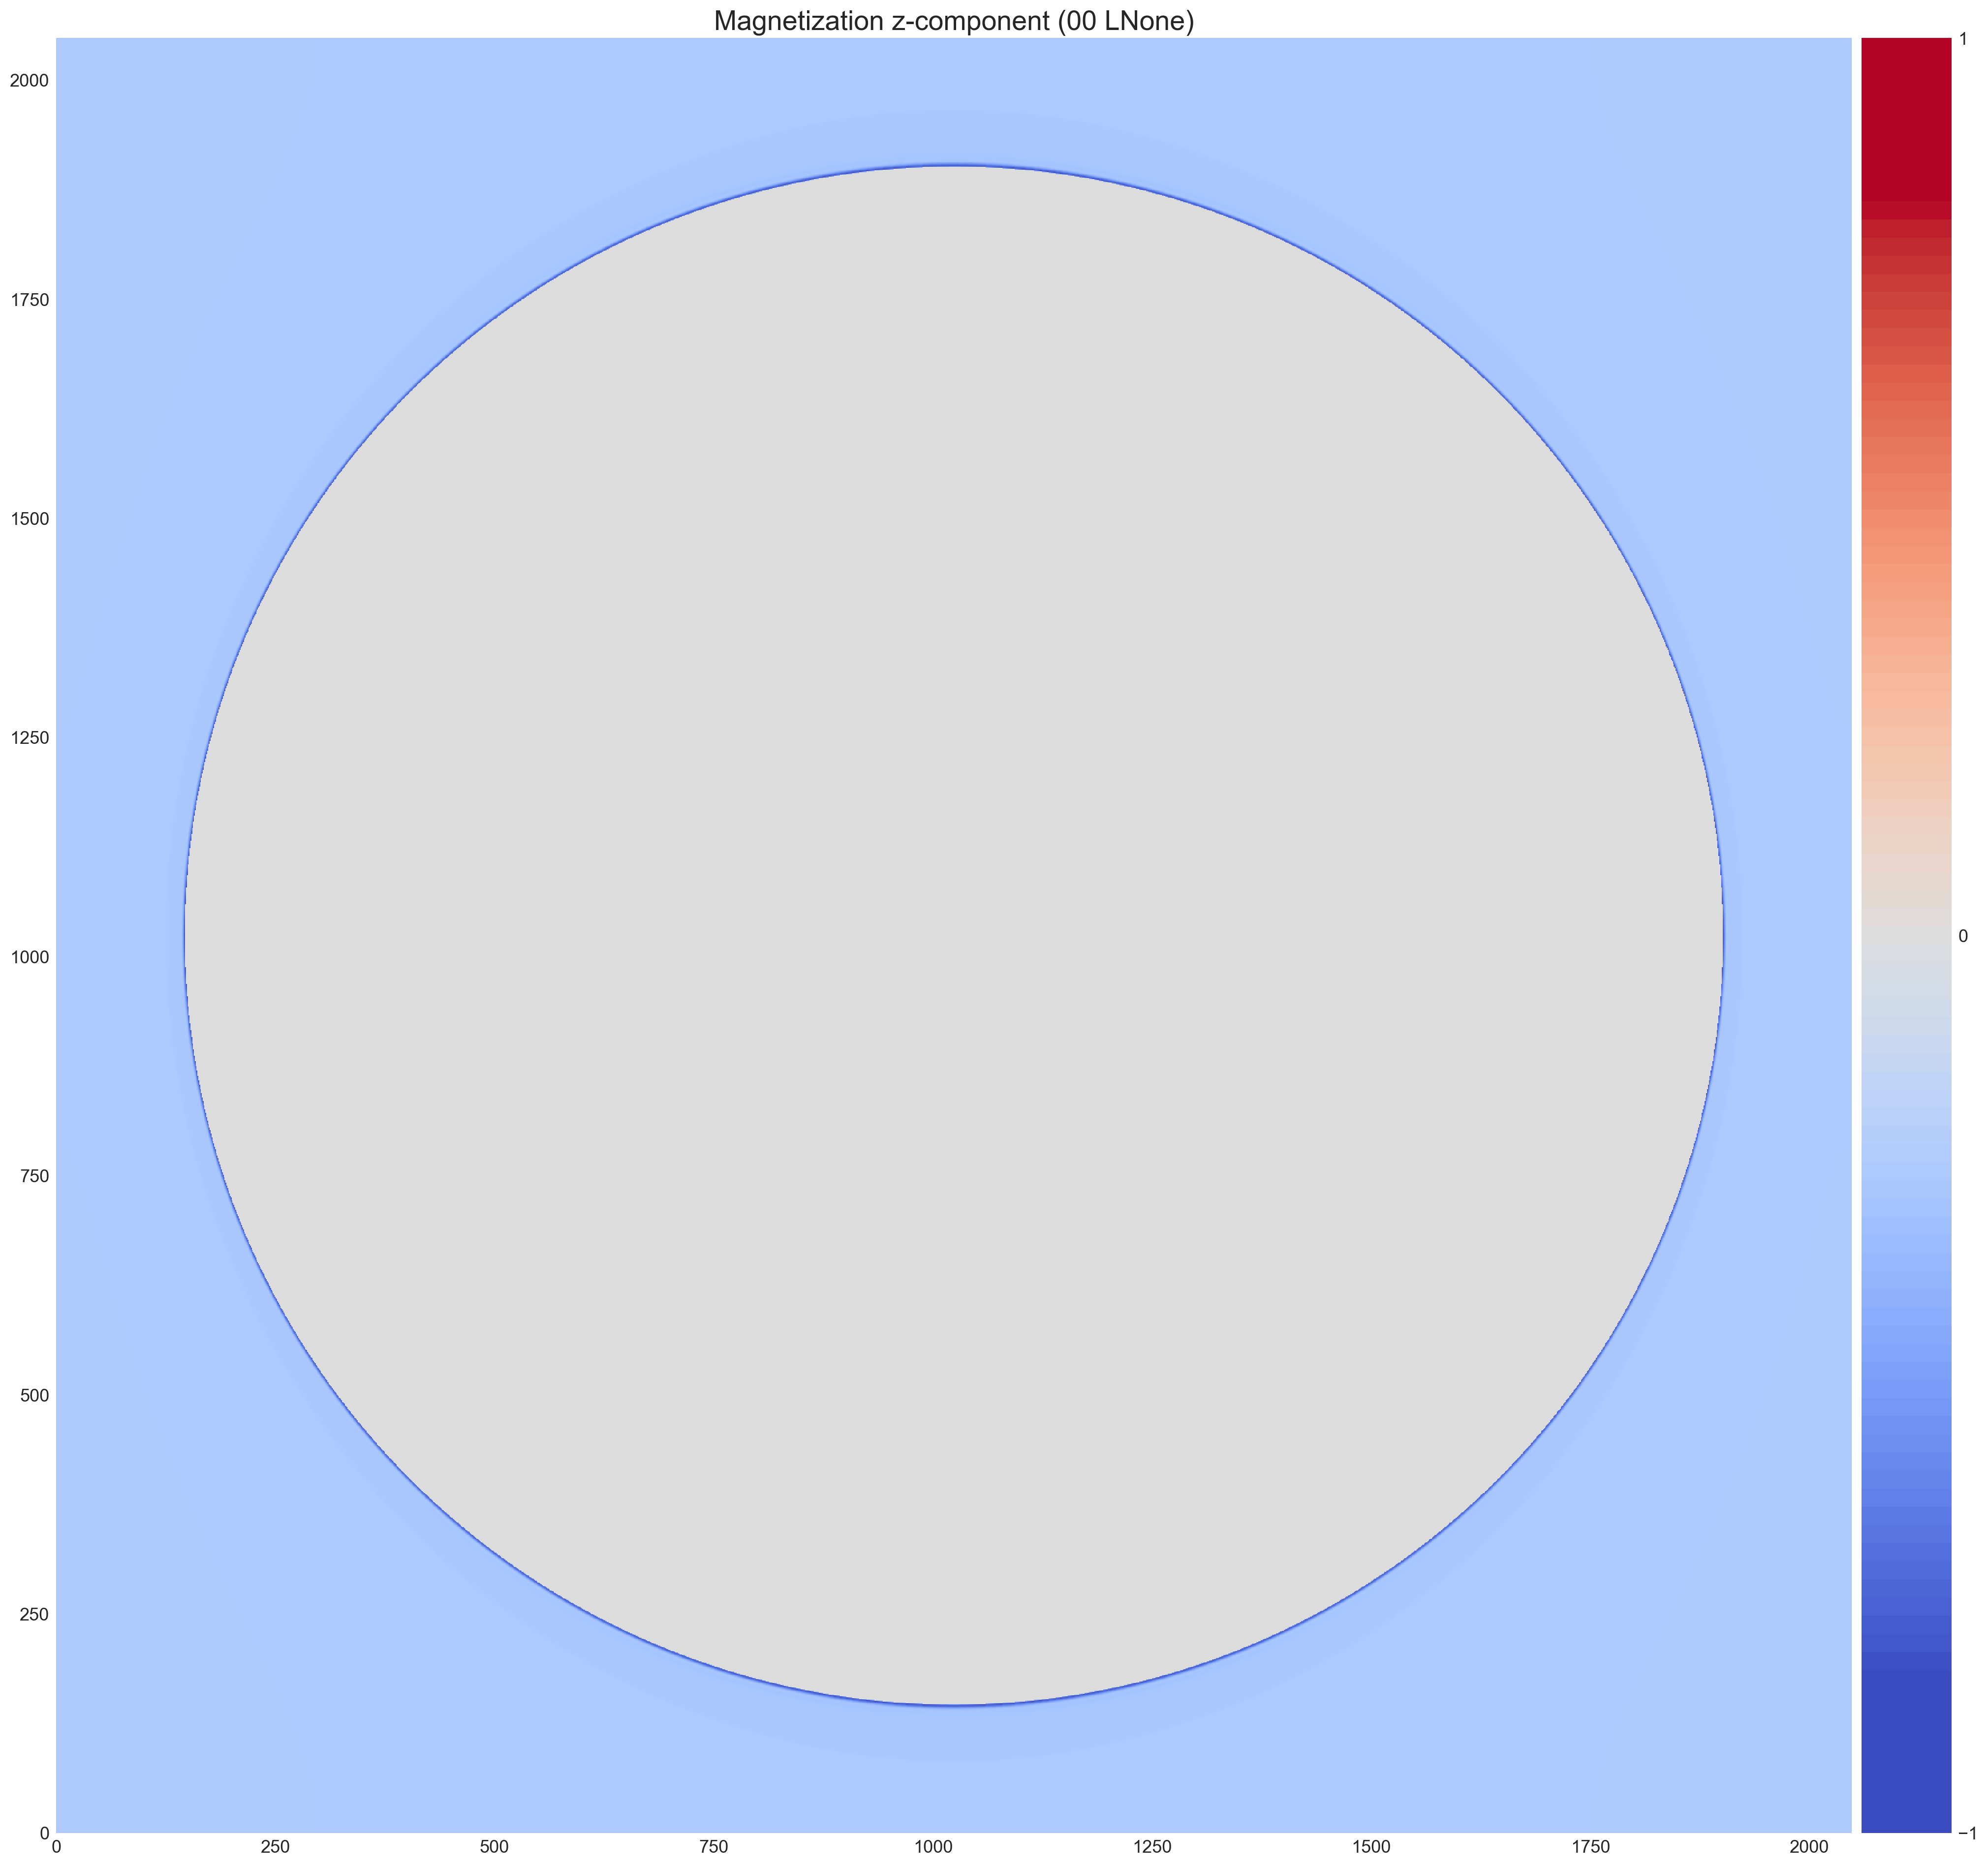

In [18]:
# same as above
layer = None
component = 2
cropx = [None,None]
cropy = [None,None]
#cropx = [1024-100,1024+100]
#cropy = [1848,2048]

# this section initializes the figure shape, color map, and color bar
fig,ax,dpi = make_1comp_fig(layer, component, cropx, cropy, figsize=(20,20), dpi=200.0)

# This block uses matplotlib FuncAnimation, which writes a frame by calling the function plot_ovf on an entry in the fnames list.
ani = FuncAnimation(fig, plot_ovf, fnames, fargs=[layer,component,cropx,cropy])
writer = PillowWriter(fps=2)
#ani.save('test.gif', writer=writer)
ani.save(f'hole_edge_2048_{lbl[component]}.gif', writer=writer, dpi=dpi)

### three components

In [ ]:
# same as above
layer = None
cropx = [None,None]
cropy = [None,None]
#cropx = [246,266]
#cropy = [0,20]

# this section initializes the figure shape, color map, and color bar
# if you get a warning, increase figsize and dpi
fig,ax,_ = make_3comp_fig(i, layer, cropx, cropy, figsize=(24,8), dpi=200.0)

ani = FuncAnimation(fig, plot_ovf_all, fnames, fargs = [layer,cropx,cropy])
writer = PillowWriter(fps=2)
ani.save('./gifs/hole gifs/35um_2048.gif', writer=writer)